In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import helper
from heapq import nlargest
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
%matplotlib inline

In [2]:
#import User data and location data
userIDSet=["0131412","0131412","2142144","0131412","0131412","0131412","1243551","3524541","2142144","1232144",
           "1232144","1232144","3524541","1243551","1243551","1243551","1232144","3524541","3524541","1232144",
           "3524541","2142144","2142144","0131412","2142144","2142144","2142144","2142144","0131412","2142144"]
latSet=[22.369453,22.364373,22.356991,22.372627,22.344501,22.351804,22.381649,22.366568,22.353709,22.379903,
        22.309567,22.313696,22.326400,22.323700,22.333545,22.313696,22.331163,22.347200,22.339261,22.327988,
        22.257332,22.250818,22.254949,22.277348,22.260192,22.288308,22.276395,22.306256,22.227302,22.238107,]
lngSet=[114.120113,114.122516,114.119254,114.108440,114.130891,114.096902,114.099477,114.150975,114.150117,114.109776,
        114.175008,114.165223,114.161618,114.188054,114.171574,114.179127,114.202645,114.182732,114.163678,114.195779,
        113.880496,113.922210,113.960834,113.915000,113.894572,113.981090,114.011646,113.918605,113.997741,113.926330]

latlngData = np.column_stack([np.array(latSet), np.array(lngSet)])

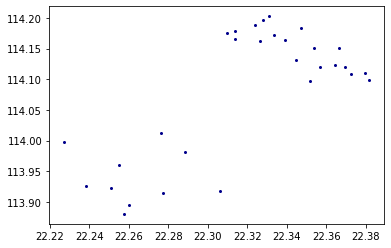

In [3]:
#visualize the data
fig, ax = plt.subplots()
ax.plot(latlngData[:, 0], latlngData[:, 1], 'o', markersize=2, c='darkblue');

In [4]:
#try different numbers of cluster
test_n_cluster = 20
within_cluster_sum_squares = np.zeros(test_n_cluster)
for i in range(test_n_cluster):
    n = i+1
    kmeans = KMeans(n_clusters = n, init = 'k-means++', max_iter=500, n_init=20, random_state = 0)
    kmeans.fit(latlngData)
    within_cluster_sum_squares[i] = kmeans.inertia_


In [5]:
#show the trend of changing number of cluster
np.set_printoptions(suppress=True)
np.around(within_cluster_sum_squares, 2)


array([0.39, 0.05, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

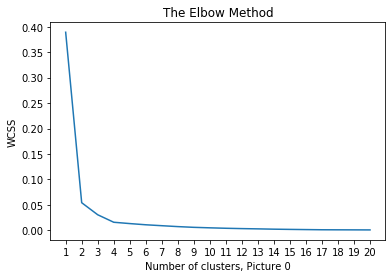

In [6]:
#visualize the trend
fig, ax = plt.subplots()
ax.plot(within_cluster_sum_squares)
xticks = np.arange(test_n_cluster)
xticklabels = xticks + 1
ax.set(xticks=xticks, xticklabels=xticklabels, title='The Elbow Method', 
       xlabel='Number of clusters, Picture 0', ylabel='WCSS');

In [7]:
#get the proper number of cluster
def ElbowMethod(array, top_cluster_number, remark=True, init = 'k-means++', max_iter = 300, n_init = 10, random_state = None):
    #import numpy as np
    #from sklearn.cluster import KMeans
    wcss = np.zeros(top_cluster_number)
    
    for i in range(top_cluster_number):
        n = i+1
        kmeans = KMeans(n_clusters = n, init=init, max_iter=max_iter, n_init=n_init, random_state=random_state)
        kmeans.fit(latlngData)
        wcss[i] = kmeans.inertia_
    
    cosines = -1 * np.ones(top_cluster_number)
    
    for i in range(top_cluster_number-1):
    # check if the point is below a segment midpoint connecting its neighbors
        if (wcss[i] < (wcss[i+1]+wcss[i-1])/2 ):
            cosines[i]= (-1+(wcss[i-1]-wcss[i])*(wcss[i+1]-wcss[i]))/ \
            ((1+(wcss[i-1]-wcss[i])**2)*(1+ (wcss[i+1]-wcss[i])**2))**.5
    
    if remark:
        print("""Remark: If repeated applications(with different random_state parameters) yield different 
        values for the optimal number then K-means method does not work well on the array.""")
    
        return (np.flip(np.argsort(cosines))+1)

suggestedNumOfCluster=ElbowMethod(latlngData, 20, max_iter=500, n_init=20)
#print(suggestedNumOfCluster)

Remark: If repeated applications(with different random_state parameters) yield different 
        values for the optimal number then K-means method does not work well on the array.


In [8]:
#convert userIDSet to numIdx
userIDBook=[]
userIDIdxSet=[]
for i in range(len(userIDSet)):
    if userIDSet[i] not in userIDBook:
        userIDBook.append(userIDSet[i])
    userIDIdxSet.append(userIDBook.index(userIDSet[i]))
#print("userIDBook:")
#print(userIDBook)
#print("userIDSet:")
#print(userIDSet)
#print("userIDIdxSet:")
#print(userIDIdxSet)


#form the dataset for clustering
numOfUser=len(userIDBook)
userIDIdx = pd.Series(userIDIdxSet)
lat = pd.Series(latSet)
lng = pd.Series(lngSet)
d = {'UserID_index':userIDIdx, 'Lat': lat, 'Lng': lng}
dataset = pd.DataFrame(d)
#print(dataset)

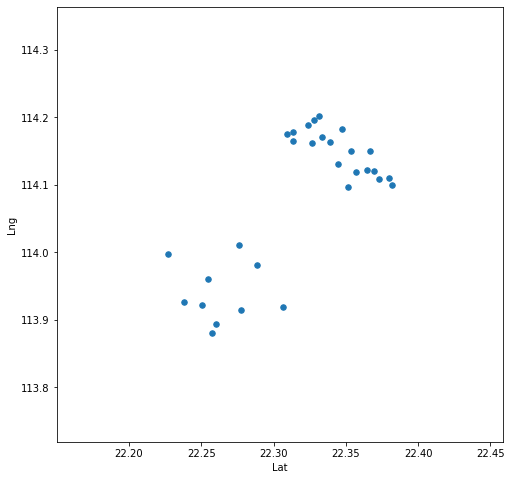

In [9]:
#clustering using helper.py
minLat=lat.min()
maxLat=lat.max()
minLng=lng.min()
maxLng=lng.max()
#print(minLat)
#print(maxLat)
#print(minLng)
#print(maxLng)
latRange=maxLat-minLat
lngRange=maxLng-minLng
lowerLat=minLat-latRange/2
upperLat=maxLat+latRange/2
lowerLng=minLng-lngRange/2
upperLng=maxLng+lngRange/2
helper.draw_scatterplot(dataset['Lat'],'Lat', dataset['Lng'], 'Lng', lowerLat, upperLat, lowerLng, upperLng)

In [10]:
#convert proper data type for clustering
X = dataset[['Lat','Lng']].values
#print("dataset(type:"+str(type(X))+")")
#print(X)

#Create an instance of KMeans
numOfClusters=suggestedNumOfCluster[1]
kmeans_1 = KMeans(n_clusters=numOfClusters, random_state=0)
#Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)

#check data value
print("X(type:"+str(type(X))+")")
print(X)
print("predictions(type:"+str(type(predictions))+")")
print(predictions)

X(type:<class 'numpy.ndarray'>)
[[ 22.369453 114.120113]
 [ 22.364373 114.122516]
 [ 22.356991 114.119254]
 [ 22.372627 114.10844 ]
 [ 22.344501 114.130891]
 [ 22.351804 114.096902]
 [ 22.381649 114.099477]
 [ 22.366568 114.150975]
 [ 22.353709 114.150117]
 [ 22.379903 114.109776]
 [ 22.309567 114.175008]
 [ 22.313696 114.165223]
 [ 22.3264   114.161618]
 [ 22.3237   114.188054]
 [ 22.333545 114.171574]
 [ 22.313696 114.179127]
 [ 22.331163 114.202645]
 [ 22.3472   114.182732]
 [ 22.339261 114.163678]
 [ 22.327988 114.195779]
 [ 22.257332 113.880496]
 [ 22.250818 113.92221 ]
 [ 22.254949 113.960834]
 [ 22.277348 113.915   ]
 [ 22.260192 113.894572]
 [ 22.288308 113.98109 ]
 [ 22.276395 114.011646]
 [ 22.306256 113.918605]
 [ 22.227302 113.997741]
 [ 22.238107 113.92633 ]]
predictions(type:<class 'numpy.ndarray'>)
[3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 2 2 1 2 1]


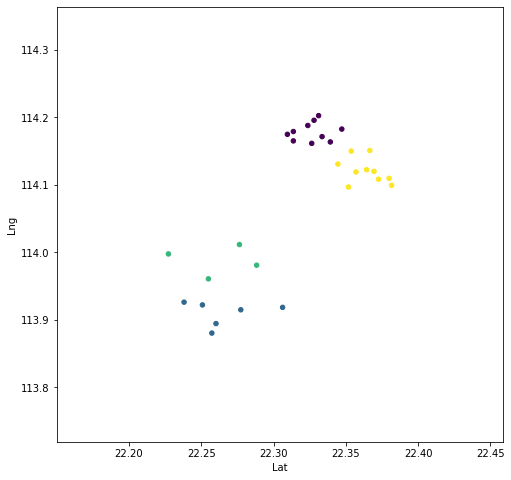

In [11]:
#visualize the result of clustering
helper.draw_clusters(dataset, predictions, 'Lat', 'Lng', lowerLat, upperLat, lowerLng, upperLng)

In [12]:
#count # of users appear in each cluster
clusters=[]
userIDArray = userIDIdx.to_numpy()
for i in range(numOfClusters):
    clusters.append([])
for i in range(len(predictions)):
    clusters[predictions[i]].append(userIDArray[i])
print(clusters)

[[4, 4, 3, 2, 2, 2, 4, 3, 3, 4], [3, 1, 0, 1, 1, 1], [1, 1, 1, 0], [0, 0, 1, 0, 0, 0, 2, 3, 1, 4]]


In [13]:
#get user avg occurence for calculation
userAvgOccurrence=[]
for i in range(numOfUser):
    currentUserOccurence=0
    for j in range(numOfClusters):
        currentUserOccurence+=clusters[j].count(i+1)
    userAvgOccurrence.append(currentUserOccurence/numOfClusters)
#print("userAvgOccurrence:")
#print(userAvgOccurrence)


#functions
def covOfUserAB(A,B):
    sONOOUAB=0 #sONOOUAB: sum of normalized occurrence of user A,B
    for i in range(numOfClusters):
        sONOOUAB+=(clusters[i].count(A)-userAvgOccurrence[A-1])*(clusters[i].count(B)-userAvgOccurrence[B-1])
    sONOOUAB=sONOOUAB/numOfClusters
    #print("soNOOUAB:")
    #print(sONOOUAB)
    return sONOOUAB

def stdDevOfUser(A):
    numerator=0
    for i in range(numOfClusters):
        numerator+=(clusters[i].count(A)-userAvgOccurrence[A-1])**2
    result=pow(numerator/numOfClusters,0.5)
    #print("result:")
    #print(result)
    return result

def simOfUserAB(A,B):
    numerator=covOfUserAB(A,B)
    denominator=(stdDevOfUser(A)*stdDevOfUser(B))
    if(denominator==0): #means all data of A and B are the same
        result=-1.0
    else:
        result=numerator/denominator
    #print("numerator:")
    #print(numerator)
    #print("denominator:")
    #print(denominator)
    #print("numerator/denominator:")
    #print(result)
    #print("------------------------")
    return result #result 1:similar, 0:no linear relationship, -1:opposite

#to find the distance matrix of all user
def getUserDistanceMatrix():
    userDistanceMatrix=[]
    for i in range(numOfUser):
        userDistanceMatrix.append([])
        for j in range(numOfUser):
            if(i>j):
                userDistanceMatrix[i].append(userDistanceMatrix[j][i])
            if(i==j):
                userDistanceMatrix[i].append(-1.0)
            if(i<j):
                userDistanceMatrix[i].append(simOfUserAB(i,j))
    print("userDistanceMatrix:")
    print(userDistanceMatrix)
    return userDistanceMatrix

#get Nth similar Users
def getNthUserMostSimilarTotarget(userID,Nth):
    if userID in userIDBook:
        targetUserIdx=userIDBook.index(userID)
        print("targetUserIdx:")
        print(targetUserIdx)
        #idxOfUserID=allUserID.copy()
        similaritiesOfUserA=getUserDistanceMatrix()[targetUserIdx].copy() #result 1:similar, 0:no linear relationship, -1:opposite
        idxForSimilaritiesOfUserA=[]
        for i in range(len(similaritiesOfUserA)):
            idxForSimilaritiesOfUserA.append(i)
        #print("idxOfUserID:")
        #print(idxOfUserID)
        print("similaritiesOfUserA:")
        print(similaritiesOfUserA)
        print("idxForSimilaritiesOfUserA:")
        print(idxForSimilaritiesOfUserA)
        result=nlargest(Nth, idxForSimilaritiesOfUserA, key=lambda i: similaritiesOfUserA[i])
        print("result:")
        print(result)

        #filter out -1 to 0 results
        #result 1:similar, 0:no linear relationship, -1:opposite
        result = [item for item in result if similaritiesOfUserA[item]>0.0]
        print("filtered result:")
        print(result)

        #get back the user ID of the result
        NthUser=[]
        for i in range(len(result)):
            #NthUser.append(idxOfUserID[result[i]])
            NthUser.append(userIDBook[result[i]])
        print("result(in user ID):")
        print(NthUser)

        return NthUser
    else:
        return []

In [14]:
#to get n similar Users
getNthUserMostSimilarTotarget("3524541",2)

targetUserIdx:
3
userDistanceMatrix:
[[-1.0, 0.08132500607904443, -0.15713484026367722, -0.24283093212859133, -0.22011272658140596], [0.08132500607904443, -1.0, -0.9660917830792959, -0.8143450710459552, -0.953747635118964], [-0.15713484026367722, -0.9660917830792959, -1.0, 0.936585811581694, 0.9961164901835046], [-0.24283093212859133, -0.8143450710459552, 0.936585811581694, -1.0, 0.9446104285307813], [-0.22011272658140596, -0.953747635118964, 0.9961164901835046, 0.9446104285307813, -1.0]]
similaritiesOfUserA:
[-0.24283093212859133, -0.8143450710459552, 0.936585811581694, -1.0, 0.9446104285307813]
idxForSimilaritiesOfUserA:
[0, 1, 2, 3, 4]
result:
[4, 2]
filtered result:
[4, 2]
result(in user ID):
['1232144', '1243551']


['1232144', '1243551']

In [15]:
#Backup testing data
#cluster 1:
#22.369453, 114.120113
#22.364373, 114.122516
#22.356991, 114.119254
#22.372627, 114.108440
#22.344501, 114.130891
#22.351804, 114.096902
#22.381649, 114.099477
#22.366568, 114.150975
#22.353709, 114.150117
#22.379903, 114.109776


#cluster 2:
#22.309567, 114.175008
#22.313696, 114.165223
#22.326400, 114.161618
#22.323700, 114.188054
#22.333545, 114.171574
#22.313696, 114.179127
#22.331163, 114.202645
#22.347200, 114.182732
#22.339261, 114.163678
#22.327988, 114.195779


#cluster 3:
#22.257332, 113.880496
#22.250818, 113.922210
#22.254949，113.960834
#22.277348, 113.915000
#22.260192, 113.894572
#22.288308, 113.981090
#22.276395, 114.011646
#22.306256, 113.918605
#22.227302, 113.997741
#22.238107，113.926330

#userID
#0: 0131412
#1: 2142144
#2: 1243551
#3: 3524541
#4: 1232144
#["0131412","0131412","2142144","0131412","0131412","0131412","1243551","3524541","2142144","1232144",
# "1232144","1232144","3524541","1243551","1243551","1243551","1232144","3524541","3524541","1232144",
# "3524541","2142144","2142144","0131412","2142144","2142144","2142144","2142144","0131412","2142144"]


In [16]:
#Backup code

[-0.213048    0.07256833 -0.1977792   0.0822872  -0.0425363   0.03908652
 -0.20986045 -0.04891002 -0.02205613 -0.03342823]
[ 0.00693196 -0.11988116 -0.19713881  0.04850418  0.00728694  0.08769389
 -0.06031104 -0.01661506 -0.25821944  0.03584884]
[1.09625176 0.95106359 1.19520416 1.251298   1.11726307 0.90967418
 0.96069158 1.13113758 1.00760109 1.06461565]
[1.11131559 1.09628071 0.9115343  1.14248507 1.0211726  1.16306936
 0.92061287 0.76429802 0.99393536 1.07793446]
[2.18102306 1.93412139 2.04795257 2.06871508 1.9754128  1.99897407
 1.9190824  1.75454454 1.98035717 2.17061264]
[1.94387289 1.89389455 2.09247375 2.06990986 2.00665737 2.03211569
 1.93810507 1.91559325 1.89694947 1.88112747]


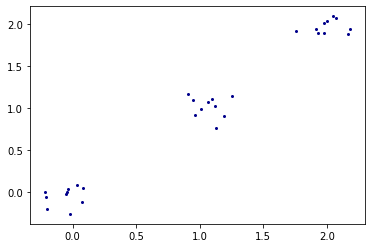

In [17]:
#Reference Sample
# number of clusters: real and assumed for testing.
true_n_cluster = 3

n_obs = 10

X = None

for i in range(true_n_cluster):
    x = np.random.normal(loc=i, size=n_obs, scale=0.1)#generate data
    y = np.random.normal(loc=i, size=n_obs, scale=0.1)#generate data
    print(x)
    print(y)
    data = np.column_stack([x, y])
    #print(data)
    if X is None:
        X = data
    else:
        X = np.row_stack([X, data])
        
#print(X)

fig, ax = plt.subplots()

ax.plot(X[:, 0], X[:, 1], 'o', markersize=2, c='darkblue');